In [1]:
# Load the tfa model 
from pytfa.io.json import load_json_model
model_file = 'reduced_model_ETC_core_20240816-155234_continuous.json'
tmodel = load_json_model(model_file)
#sol = tmodel.optimize()

2024-08-27 13:18:10,707 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


In [2]:
# Reload and prepare the model
from skimpy.io.yaml import load_yaml_model
from skimpy.utils.tabdict import TabDict

kmodel = load_yaml_model(model_file.replace("_continuous.json", "_kinetic_curated.yml"))

# We calculate control coeffcients with respect
#  to enzyme activity and boundary concentrations
parameter_list = TabDict([(k, p.symbol) for k, p in kmodel.parameters.items() if p.name.startswith('vmax_forward')])
boundary_parameters = TabDict([(c.reactant.name, c.reactant.symbol) for c in kmodel.boundary_conditions.values()])
parameter_list.update(boundary_parameters)

# Compile the jacobian expressions
NCPU = 12
kmodel.prepare()
kmodel.compile_mca(ncpu=NCPU, parameter_list=parameter_list)

In [3]:
# Load TFA samples 
import pandas as pd
tfa_sample_file = 'reduced_model_ETC_core_20240816-155234_tfa_sampling.csv'
tfa_samples = pd.read_csv(tfa_sample_file)

In [4]:
# Load parameter samples 
from skimpy.core.parameters import load_parameter_population
parameter_population = load_parameter_population(tfa_sample_file.replace(".csv",'_pruned_parameters.hdf5'))

In [5]:
# Scaling parameters
CONCENTRATION_SCALING = 1e3 # 1 mol to 1 umol
TIME_SCALING = 1 # 1min
DENSITY = 1200 # g/L 
GDW_GWW_RATIO = 1.0 # Fluxes are in gWW

In [6]:
# Parameter selection 
from skimpy.analysis.oracle.load_pytfa_solution import load_fluxes, load_concentrations,\
    load_equilibrium_constants
import numpy as np

flux_controll_coefficients = []
parameter_sample_ids = []

for k in parameter_population._index:

    parameter_values = parameter_population[k]

    i = int(k.split(',')[0]) 
    ref_solution = tfa_samples.loc[i]


    # Load fluxes and concentrations
    fluxes = load_fluxes(ref_solution, tmodel, kmodel,
                            density=DENSITY,
                            ratio_gdw_gww=GDW_GWW_RATIO,
                            concentration_scaling=CONCENTRATION_SCALING,
                            time_scaling=TIME_SCALING)
    
    concentrations = load_concentrations(ref_solution, tmodel, kmodel,
                                            concentration_scaling=CONCENTRATION_SCALING)
    
    this_fc = kmodel.flux_control_fun(fluxes,concentrations,[parameter_values, ])

    # Prune for positive substrate control
    medium_control = this_fc.slice_by('sample', 0).loc[['L_LACt2r','GLCt1r', 'FATP1t', 'BHBt'],
                                                       ['lac_L_e', 'glc_D_e', 'hdca_e', 'bhb_e']]
    diag_is_positive = np.all(np.diag(medium_control.values) > 0)

    if diag_is_positive:
        flux_controll_coefficients.append(this_fc)
        parameter_sample_ids.append(k)


In [7]:
# Make a pruned parameter population
from skimpy.core.parameters import ParameterValuePopulation
parameter_population_pruned = [parameter_population[k] for k in parameter_sample_ids]
parameter_population_pruned = ParameterValuePopulation(parameter_population_pruned, kmodel=kmodel, index=parameter_sample_ids)

In [8]:
# Stack the results
from skimpy.utils.tensor import Tensor
import numpy as np
# Concat the data
data = np.concatenate([f._data for f in flux_controll_coefficients], axis=2)
# Conver to tensor 
indexes = flux_controll_coefficients[0].indexes['flux'], flux_controll_coefficients[0].indexes['parameter'], pd.Index(parameter_sample_ids, name='samples')
control_coefficients = Tensor(data, indexes )


In [9]:
print(f"{len(parameter_sample_ids)} models selectet which is  {len(parameter_sample_ids) / len( parameter_population._data) * 100:.1f}% of all the models")

582 models selectet which is  81.7% of all the models


In [10]:
# Prepare the model to run an ODE simulaiton
kmodel.compile_ode(ncpu=NCPU)

In [11]:
# Build function to compute fluxes from concentrations
from skimpy.analysis.ode.utils import make_flux_fun
from skimpy.utils.namespace import QSSA

flux_function = make_flux_fun(kmodel, QSSA)

In [12]:
from skimpy.core.parameters import ParameterValues
from tqdm import tqdm

# Function for population analysis

def steady_state_perturbation(parameter, range=np.logspace(-1,1,51,base=2) , 
                            additional_parameter_changes={},
                            time = np.logspace(-3, 1, 100) - 1e-3, # 1uhr to 10hr
                            parameter_population=parameter_population_pruned, 
                            kmodel=kmodel, 
                            flux_function=flux_function,
                            tfa_samples=tfa_samples, 
                            end_ix=-1
                            ):
    
    # List of dataframes
    results = []

    # Run the perturbation for each parameterset
    parameter_population_index = list(parameter_population._index.keys())
    for parameter_set_id in tqdm(parameter_population_index[:end_ix]):

        # This will be a list of dataframes
        this_results = []

        thermo_index = int(parameter_set_id.split(',')[0])
        thermo_sample = tfa_samples.loc[thermo_index]

        concentrations = load_concentrations(thermo_sample, tmodel, kmodel, 
                                            concentration_scaling=CONCENTRATION_SCALING)

        for k in kmodel.initial_conditions:
                kmodel.initial_conditions[k] = concentrations[k]

        # Load the parameter values 
        kmodel.parameters = parameter_population[parameter_set_id]

        # Integrate additional parameters changes (fold changes)
        for k, v in additional_parameter_changes.items():
            kmodel.parameters[k].value = kmodel.parameters[k].value * v

        # Perturb the main parameter
        p0 = kmodel.parameters[parameter].value
        for perturbation_value in range:
            kmodel.parameters[parameter].value = perturbation_value * p0
            # Dynamic solution            
            sol = kmodel.solve_ode(time, solver_type='cvode' , max_steps=1e9,)
            # Get steady state concentrations
            steady_state_concentrations = sol.concentrations.iloc[-1]

            # Compute the fluxes at steady state
            # Get parameters value set 
            parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
            parameter_values = ParameterValues(parameter_values, kmodel)

            steady_state_fluxes = pd.Series(flux_function(steady_state_concentrations, parameters=parameter_values), 
                                            index=kmodel.reactions.keys())
            
            # Add the results to a dataframe 
            steady_state_output = pd.concat([steady_state_concentrations, steady_state_fluxes])
            # Add metadata 
            steady_state_output['pertubration'] = perturbation_value
            steady_state_output['parameter_set'] = parameter_set_id
            steady_state_output['parameter'] = parameter    
            steady_state_output['aditional_parameters'] = [f'{k}:{v:.1f}' for k,v in additional_parameter_changes.items()]

            this_results.append(steady_state_output)

        # Concatenate the results
        this_results = pd.concat(this_results, axis=1).T
        results.append(this_results)

    # Concatenate the results
    results = pd.concat(results)
    return results


In [13]:
# Compute perturbations for each fuel concentration
parameters = ['lac_L_e', 'glc_D_e', 'hdca_e', 'bhb_e']
results = [steady_state_perturbation(p) for p in parameters]
results = pd.concat(results)    


  0%|          | 0/581 [00:00<?, ?it/s]

 47%|████▋     | 272/581 [19:56:08<1:53:37, 22.06s/it]    
[CVODE ERROR]  CVode
  At t = 0.868199, the right-hand side routine failed in an unrecoverable manner.



In [ ]:
# Save the results
name = model_file.replace('.json', '')
results.to_csv(f'output/{name}_steady_state_perturbation.csv')

In [ ]:
uptake_fluxes = ['L_LACt2r','GLCt1r', 'FATP1t', 'BHBt']

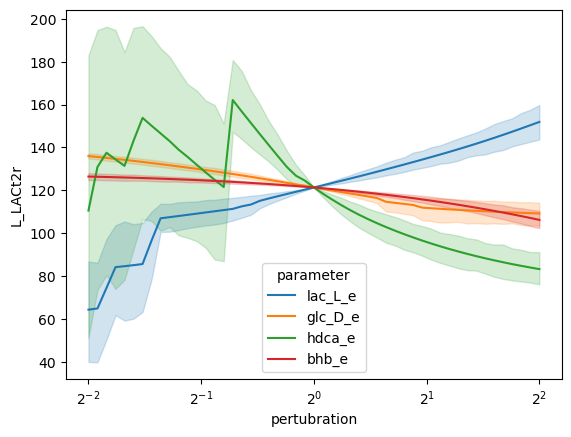

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 
# Plot the results as line plot 
sns.lineplot(data=results, x='pertubration', y='L_LACt2r', hue='parameter')
plt.xscale('log', base=2)


,coa_m,aacoa_m,accoa_m,icit_m,cit_m,adp_c,atp_c,amp_c,h_c,succoa_m,...,SUCOAS1m,TPI,cyt_atp2adp,r0205,r0509,r2435,pertubration,parameter_set,parameter,aditional_parameters
0,0.003859,0.000417,0.484774,0.001836,0.489906,0.000523,0.008244,0.000103,0.000063,0.017067,...,-525.515256,10.729005,7216.564514,34.319578,532.351404,47.9792,0.25,"1,0",lac_L_e,[]
1,0.003645,0.000449,0.484764,0.001902,0.506415,0.000515,0.008254,0.000101,0.000063,0.017259,...,-525.328788,10.727416,7216.57217,32.939028,532.31401,47.917245,0.264255,"1,0",lac_L_e,[]
2,0.003483,0.000476,0.484846,0.001952,0.519132,0.00051,0.00826,0.0001,0.000063,0.017312,...,-525.181917,10.725547,7216.577066,32.020519,532.276685,47.852867,0.279322,"1,0",lac_L_e,[]
3,0.00335,0.0005,0.484977,0.001995,0.529762,0.000506,0.008265,0.000099,0.000063,0.01729,...,-525.054961,10.72341,7216.580478,31.329879,532.238928,47.787272,0.295248,"1,0",lac_L_e,[]
4,0.003236,0.000522,0.48514,0.002031,0.53898,0.000504,0.008268,0.000099,0.000063,0.017218,...,-524.940289,10.720995,7216.582892,30.776263,532.200743,47.721037,0.312083,"1,0",lac_L_e,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,0.001077,0.010112,0.086896,0.004412,1.140956,0.000527,0.008291,0.000042,0.000063,0.008725,...,-507.111104,10.585262,7216.718274,34.638995,544.304399,42.318963,3.20428,"2,7",bhb_e,[]
47,0.001063,0.01081,0.086334,0.00444,1.148418,0.000527,0.008291,0.000042,0.000063,0.008601,...,-506.431528,10.584555,7216.718275,35.651024,544.981866,42.181804,3.386981,"2,7",bhb_e,[]
48,0.00105,0.011552,0.085723,0.004466,1.155189,0.000527,0.008291,0.000042,0.000063,0.008484,...,-505.744868,10.583872,7216.718268,36.737447,545.676548,42.044836,3.5801,"2,7",bhb_e,[]
49,0.001038,0.01234,0.08506,0.004489,1.161338,0.000527,0.008291,0.000042,0.000063,0.008371,...,-505.051349,10.583216,7216.718256,37.902723,546.387601,41.907474,3.784231,"2,7",bhb_e,[]
